In [2]:
import time
import os
import math
import cv2
import numpy as np
import pandas as pd
import pyautogui as pa
import shutil
import imageio
from PIL import Image, ImageDraw
import random
from scipy.stats import norm, kstest, sem, ttest_ind, linregress
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

from lib.analysis.trace_metrics import TraceMetrics
from lib.analysis.false_discovery_control import false_discovery_control
from lib.auto_GUI.auto_PhotoZ import AutoPhotoZ
from lib.analysis.laminar_dist import * 
from lib.file.TIF import *
from lib.analysis.align import ImageAlign
from lib.utilities import *
from lib.file.ROI_writer import ROIFileWriter
from lib.file.ROI_reader import ROIFileReader
from lib.analysis.barrel_roi import Barrel_ROI_Creator


In [3]:
# load trace files from the following directory
data_dir = "C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/single-cell-threshold/"
export_summary = data_dir + "export_summary_backup.csv"
theta_catalog = data_dir + "theta_catalog.csv"

camera_program = 4
um_per_px = 6.0 #um

# read in theta catalog
theta_catalog_df = pd.read_csv(theta_catalog)
theta_catalog_df

,Date,Slice,Location,Recording,Stim_Current,Electrode_Type,Slice_Type,Drug,Activation_Threshold
0,7/19/2024,2,1,1,100,single,coronal,ACSF,90.0
1,7/19/2024,2,1,2,60,single,coronal,ACSF,90.0
2,7/19/2024,2,1,3,120,single,coronal,ACSF,90.0
3,7/19/2024,2,1,4,80,single,coronal,ACSF,90.0
4,7/19/2024,2,1,5,100,extracellular,coronal,ACSF,90.0
5,7/19/2024,2,1,6,70,single,coronal,ACSF,90.0
6,7/19/2024,2,1,7,80,single,coronal,ACSF,90.0
7,10/23/2024,2,1,1,50,single,coronal,ACSF,40.0
8,10/23/2024,2,1,2,30,single,coronal,ACSF,40.0
9,10/23/2024,2,1,3,20,single,coronal,ACSF,40.0


In [4]:
def read_traces_file(filename): 
    data_arr = pd.read_csv(filename,
                                 sep='\t',
                                 header=0)
    return data_arr

# open export summary csv
df_export = pd.read_csv(export_summary)

# divide amp by 1000
df_export['amp'] = df_export['amp'] / 1000

# join the two dataframes on Date, Slice, Location, and Recording matches
df_export = pd.merge(df_export, theta_catalog_df, on=['Date', 'Slice', 'Location', 'Recording'])

df_export

,ROI,amp,X_Center,Y_Center,ROI_Set,Date,Slice,Location,Recording,trace,Stim_Current,Electrode_Type,Slice_Type,Drug,Activation_Threshold
0,1,0.001075,52.403050,48.725490,2_rois,10/23/2024,2,1,1,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,50,single,coronal,ACSF,40.0
1,1,0.000375,52.403050,48.725490,2_rois,10/23/2024,2,1,2,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,30,single,coronal,ACSF,40.0
2,1,0.000115,52.403050,48.725490,2_rois,10/23/2024,2,1,3,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,20,single,coronal,ACSF,40.0
3,1,0.000420,52.403050,48.725490,2_rois,10/23/2024,2,1,4,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,30,single,coronal,ACSF,40.0
4,1,0.000585,52.403050,48.725490,2_rois,10/23/2024,2,1,5,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,20,extracellular,coronal,ACSF,40.0
5,1,0.000224,52.403050,48.725490,2_rois,10/23/2024,2,1,6,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,20,single,coronal,ACSF,40.0
6,1,0.001434,52.403050,48.725490,2_rois,10/23/2024,2,1,7,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,50,extracellular,coronal,ACSF,40.0
7,1,0.001506,52.403050,48.725490,2_rois,10/23/2024,2,1,8,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,50,extracellular,coronal,NBQX,NaN
8,1,0.000620,52.403050,48.725490,2_rois,10/23/2024,2,1,9,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,50,single,coronal,NBQX,NaN
9,1,0.000429,52.403050,48.725490,2_rois,10/23/2024,2,1,10,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,30,single,coronal,NBQX,NaN


In [5]:
# make a new dataframe with normalized amp and current
df_export_norm = df_export.copy()

# restrict to Drug == ACSF only
df_export_norm = df_export_norm[df_export_norm['Drug'] == 'ACSF']

# min-max normalize the amp, each Date/Slice is normalized independently
df_export_norm['amp'] = (df_export_norm['amp'] - 
                         df_export_norm.groupby(['Date', 'Slice'])['amp'].transform('min')) / \
                        (df_export_norm.groupby(['Date', 'Slice'])['amp'].transform('max') - 
                        df_export_norm.groupby(['Date', 'Slice'])['amp'].transform('min'))   

# center the current on the Activation_Threshold (via subtraction only)
df_export_norm['Stim_Current'] = df_export_norm['Stim_Current'] - df_export_norm['Activation_Threshold']

c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\pandas\core\arraylike.py:397:

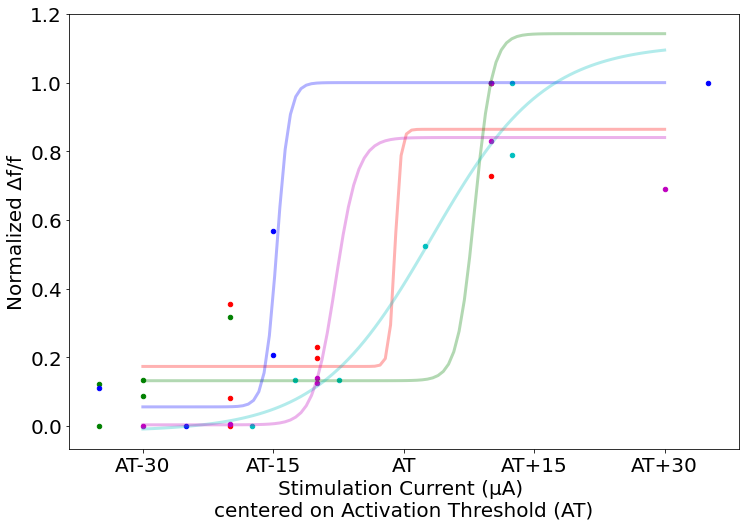

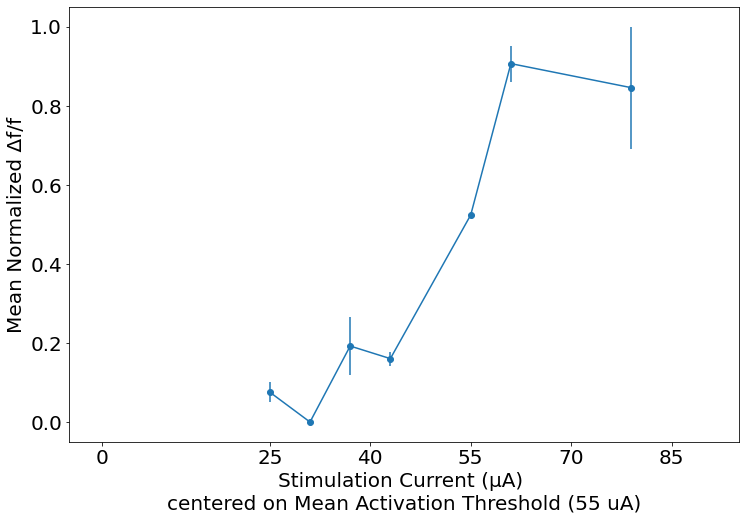

In [6]:
# make plots of amp vs. Stim_Current, with  different shape for each Date/Slice 
# and different color for each Date/Slice

# set matplotlib font size
plt.rcParams.update({'font.size': 20})

# define the logistic function
def logistic_fn(x, L, k, c, x0 , y0):
    return L / (1 + c * np.exp(-k*(x-x0))) + y0

fig, ax = plt.subplots(figsize=(12, 8))
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
i = 0
for key, grp in df_export_norm.groupby(['Date', 'Slice']):
    ax = grp.plot(ax=ax, kind='scatter', x='Stim_Current', y='amp', marker='o', color=colors[i])

    # fit a logisitic curve to this group's data and plot it
    x = grp['Stim_Current']
    y = grp['amp']
    p0 = {'c': [0.9, 3, 0.05, 0, 0.1],
          'r': [0.9, 3, 0.05, 0, 0.1],
          'b': [0.9, 1, 0.05, 0, 0.1],
          'm': [0.9, 1, 0.05, 0, 0],
          'g': [0.9, 1, 0.05, 10, 0.1] }[colors[i]]
    try:
        popt, pcov = curve_fit(logistic_fn, x, y, p0=p0)
    except:
        print("Failed to fit logistic curve for group", key, "color" , colors[i])
        i += 1
        continue
    x_fit = np.linspace(-30, 30, 100)
    y_fit = logistic_fn(x_fit, *popt)
    ax.plot(x_fit, y_fit, color=colors[i], alpha=0.3, linewidth=3)
    
    i += 1
ax.set_xlabel('Stimulation Current (μA) \ncentered on Activation Threshold (AT)')
ax.set_ylabel('Normalized Δf/f')

# set xticks from -30, -15, 0, 15, 30 to labels
ax.set_xticks([-30, -15, 0, 15, 30])
ax.set_xticklabels(['AT-30', 'AT-15', 'AT', 'AT+15', 'AT+30'])
plt.savefig(data_dir + "amp_vs_stim_current.png")
plt.show()

# Now bin the data by Stim_Current and plot the mean and SEM of amp for each bin
# use 10 bins from -30 to 30
df_export_norm['Stim_Current_bin'] = pd.cut(df_export_norm['Stim_Current'], bins=10, labels=False)
df_export_norm['Stim_Current_bin'] = df_export_norm['Stim_Current_bin'] * 6 - 30

fig, ax = plt.subplots(figsize=(12, 8))
df_export_norm.groupby('Stim_Current_bin')['amp'].mean().plot(ax=ax, yerr=df_export_norm.groupby('Stim_Current_bin')['amp'].sem(), 
                        marker='o')
ax.set_xlabel('Stimulation Current (μA) \ncentered on Mean Activation Threshold (55 uA)')
ax.set_ylabel('Mean Normalized Δf/f')
ax.set_xticks([-55, -30, -15, 0, 15, 30])
ax.set_xticklabels(['0', '25', '40', '55', '70', '85'])
ax.set_xlim(-60, 40)
plt.savefig(data_dir + "amp_vs_stim_current_binned.png")
plt.show()






10/23/2024 2 1 1


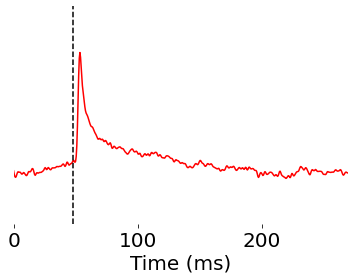

10/23/2024 2 1 2


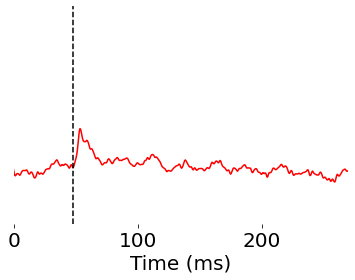

10/23/2024 2 1 3


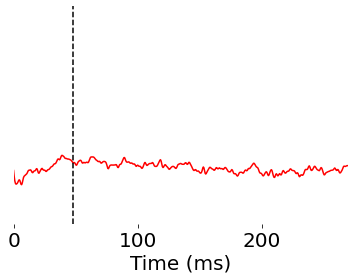

10/23/2024 2 1 4


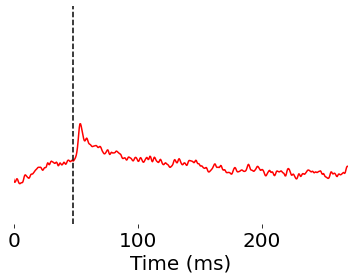

10/23/2024 2 1 5


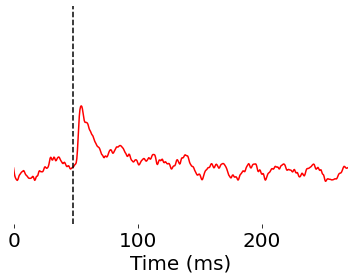

10/23/2024 2 1 6


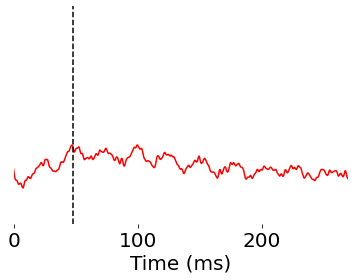

10/23/2024 2 1 7


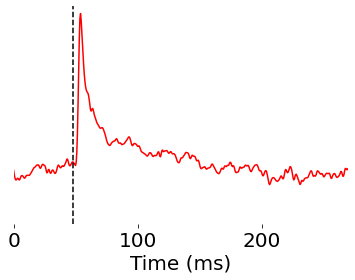

10/23/2024 2 1 8


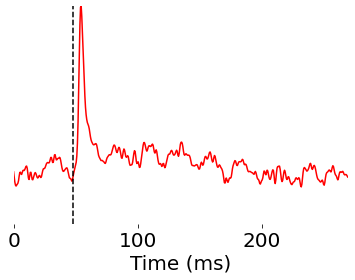

10/23/2024 2 1 9


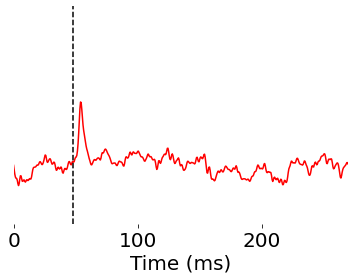

10/23/2024 2 1 10


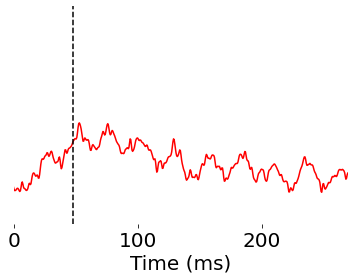

10/23/2024 2 1 11


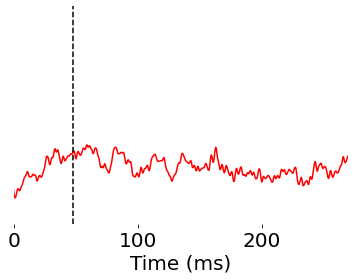

10/23/2024 2 1 12


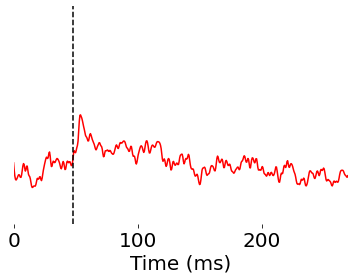

10/23/2024 2 1 13


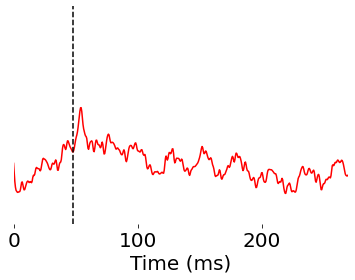

10/23/2024 3 1 1


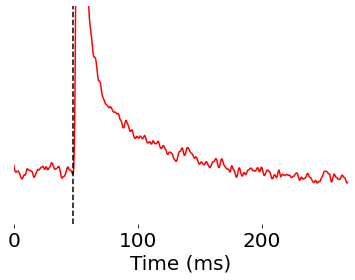

10/23/2024 3 1 2


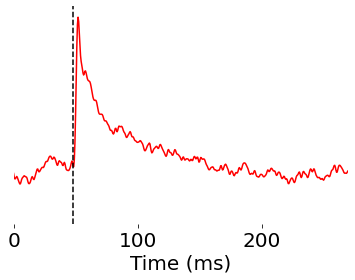

10/23/2024 3 1 3


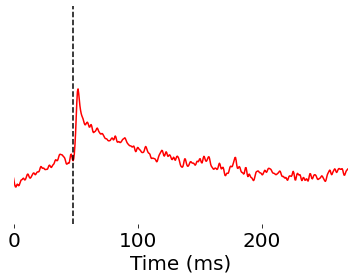

10/23/2024 3 1 4


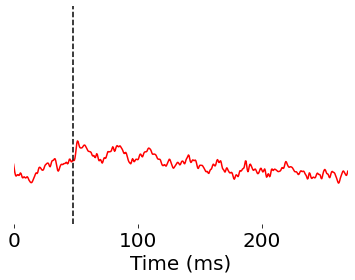

10/23/2024 3 1 5


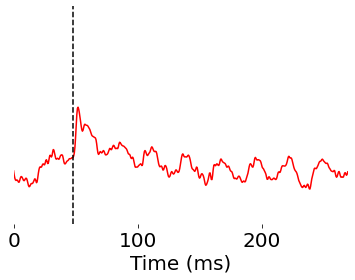

10/23/2024 3 1 6


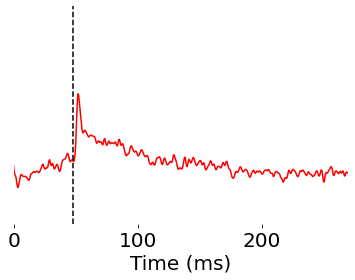

10/29/2024 2 1 1


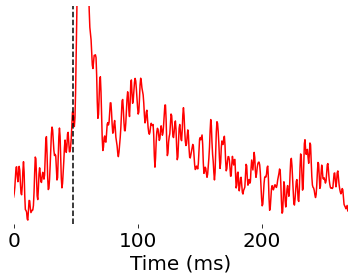

10/29/2024 2 1 2


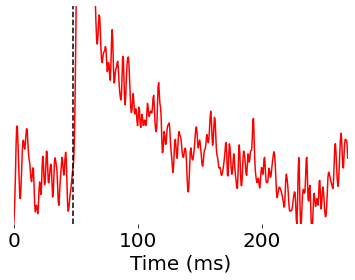

10/29/2024 2 1 3


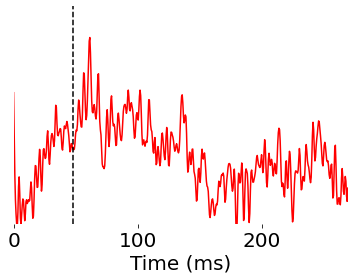

10/29/2024 2 1 4


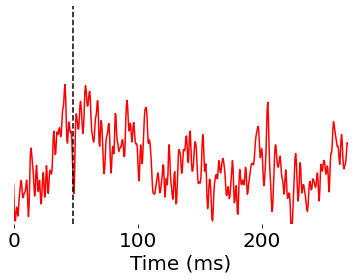

10/29/2024 2 1 5


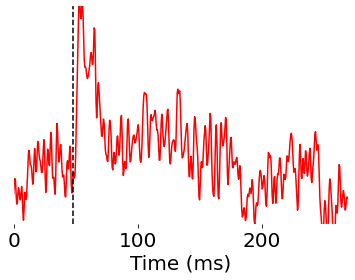

10/29/2024 3 1 1


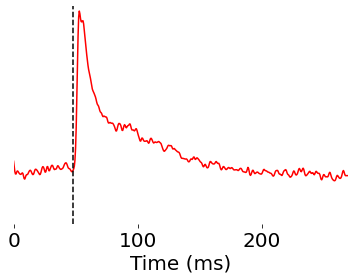

10/29/2024 3 1 2


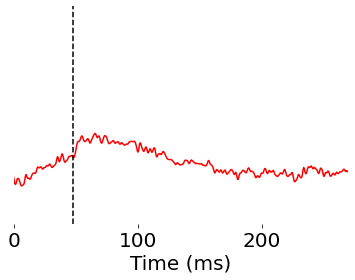

10/29/2024 3 1 3


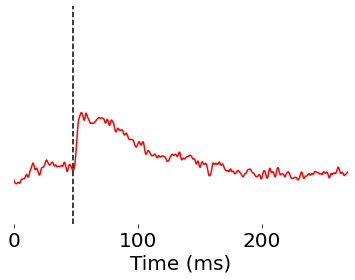

10/29/2024 3 1 4


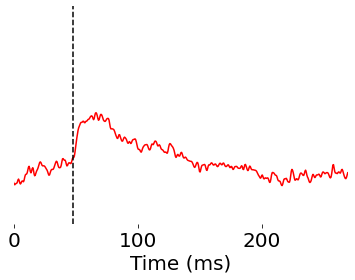

10/29/2024 3 1 5


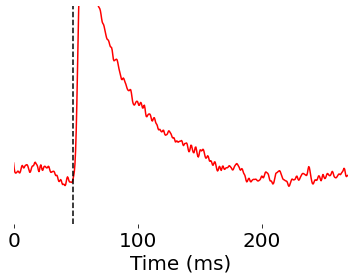

10/29/2024 3 1 6


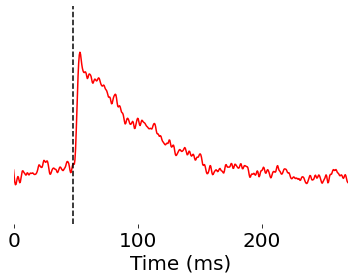

10/29/2024 3 1 7


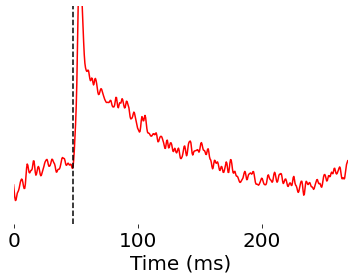

10/29/2024 3 1 8


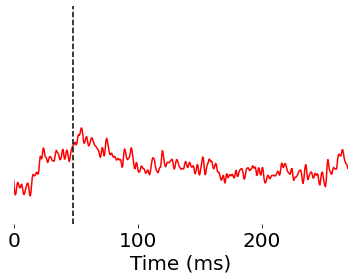

10/29/2024 3 1 9


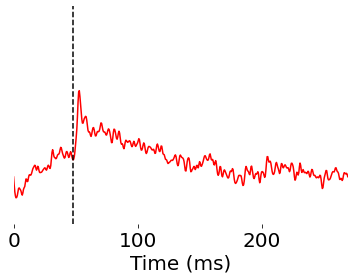

10/29/2024 3 1 10


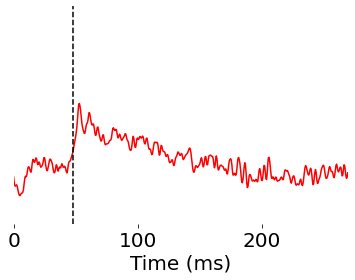

10/29/2024 3 1 11


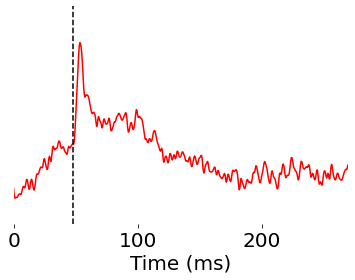

7/19/2024 2 1 1


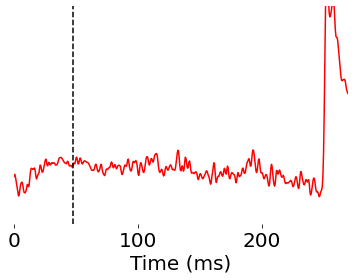

7/19/2024 2 1 2


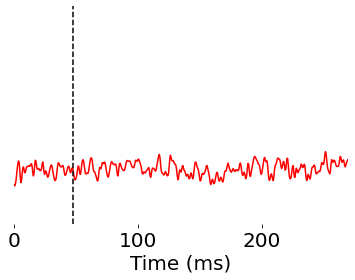

7/19/2024 2 1 3


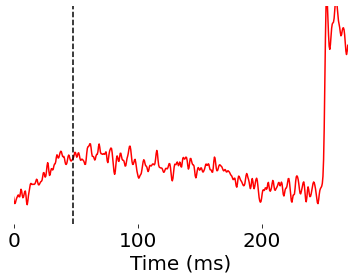

7/19/2024 2 1 4


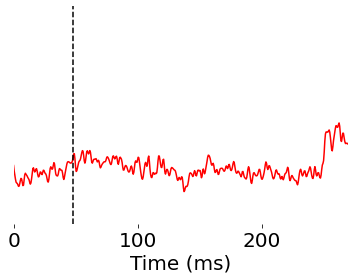

7/19/2024 2 1 5


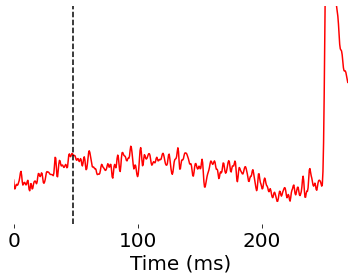

7/19/2024 2 1 6


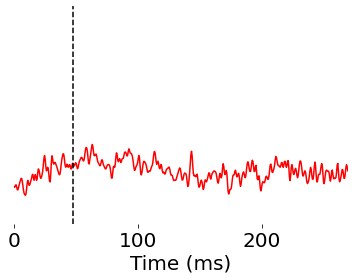

7/19/2024 2 1 7


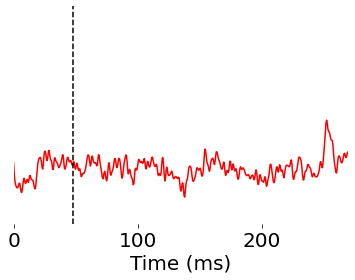

In [7]:
# plot the traces from 10/23/24 slice 2
for date in df_export['Date'].unique():
    date_df = df_export[df_export['Date'] == date]
    for slic in date_df['Slice'].unique():
        slic_df = date_df[date_df['Slice'] == slic]
        for loc in slic_df['Location'].unique():
            loc_df = slic_df[slic_df['Location'] == loc]
            for rec in loc_df['Recording'].unique():
                rec_df = loc_df[loc_df['Recording'] == rec]
                
                print(date, slic, loc, rec)
                trace_file = rec_df['trace'].values[0]

                # read in the trace file
                trace = read_traces_file(trace_file)
                tm = TraceMetrics(trace)
                tm.show_traces(measure_window=[0, 540], 
                                legend=False, 
                                colors=['r', 'cyan', 'm', 'orange', 'green', 'purple',
                                        'r', 'green', 'cyan', 'm', 'yellow', 'g', 'y', 'm', 'c', 'k'],
                                stim_time=48.3,
                                ylim=[-0.5, 1.5],
                                        )
                    

In [8]:


    
                        print(date, slic_loc_id)
                        

NameError: name 'slic_loc_id' is not defined

## 